In [1]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math
import fceulib
import networkx as nx
import nxpd
import sets
# TODO: UnionFind, probably via import

/Users/jcosborn/.virtualenvs/mechlearn/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: the sets module is deprecated


In [2]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

In [3]:
inputVec = fceulib.readInputs('movie.fm2')
collisions = pickle.load(open('collisions.pkl'))

(modes, path, merged, unions, track, all_times) = pickle.load(open("modes.pkl"))

# TODO: define axis elsewhere?
axis = 2
velocities = track[1:,axis]-track[:-1,axis] 

In [4]:
start_time = 270
transitions = {}
# Edges into [outer] from [inner]
entries_from = {m: {m: [] for m in merged} 
                for m in merged}
# Edges into [outer]
entries = {m: [] for m in merged}
for t in range(1,len(path)):
    if t == 0:
        prev = -1
    else:
        prev = unions[t-1]
    start = path[t][1][0]
    entries_from[unions[t]][prev].append(start)
    entries[unions[t]].append(start)
    transitions[all_times[start]] = (prev,unions[t])
    print (start,all_times[start]),":",prev,"->",unions[t],"\n",path[unions[t]][1][2][0],path[unions[t]][1][2][1].params

(5, 59) : 4 -> 5 
accN [ 0.         -4.01075269  0.11568409]
(13, 84) : 5 -> 6 
acc0 [ 0.          0.33684211]
(14, 93) : 6 -> 7 
cN [ 0.          4.08333333]
(16, 105) : 7 -> 4 
c0 [ 0.]
(18, 114) : 4 -> 5 
accN [ 0.         -4.01075269  0.11568409]
(26, 144) : 5 -> 6 
acc0 [ 0.          0.33684211]
(27, 154) : 6 -> 7 
cN [ 0.          4.08333333]
(29, 166) : 7 -> 8 
accN [ 0.  5. -4.]
(31, 168) : 8 -> 4 
c0 [ 0.]
(33, 174) : 4 -> 5 
accN [ 0.         -4.01075269  0.11568409]
(38, 190) : 5 -> 6 
acc0 [ 0.          0.33684211]
(43, 207) : 6 -> 40 
accN [ 0.  5. -3.]
(45, 209) : 40 -> 4 
c0 [ 0.]
(48, 215) : 4 -> 5 
accN [ 0.         -4.01075269  0.11568409]
(50, 228) : 5 -> 6 
acc0 [ 0.          0.33684211]
(51, 230) : 6 -> 6 
acc0 [ 0.          0.33684211]
(52, 238) : 6 -> 7 
cN [ 0.          4.08333333]
(54, 245) : 7 -> 4 
c0 [ 0.]
(57, 256) : 4 -> 5 
accN [ 0.         -4.01075269  0.11568409]
(60, 269) : 5 -> 6 
acc0 [ 0.          0.33684211]
(61, 271) : 6 -> 6 
acc0 [ 0.          0

4 {'type': 'c0'}
5 {'acc': 0.11568409343715233, 'type': 'accN', 'N': -4.0107526881720412}
6 {'acc': 0.33684210526315783, 'type': 'acc0'}
7 {'type': 'cN', 'N': 4.083333333333333}
8 {'acc': -3.9999999999999991, 'type': 'accN', 'N': 4.9999999999999991}
40 {'acc': -2.9999999999999996, 'type': 'accN', 'N': 4.9999999999999991}
53 {'acc': 0.42105263157894735, 'type': 'accN', 'N': -3.5263157894736836}


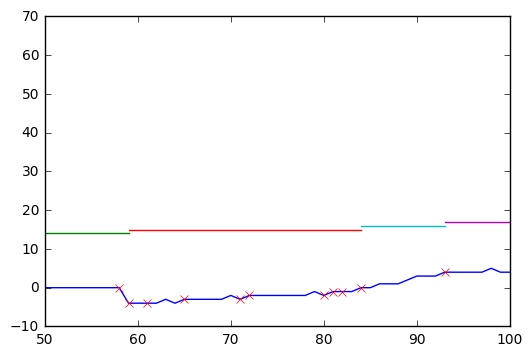

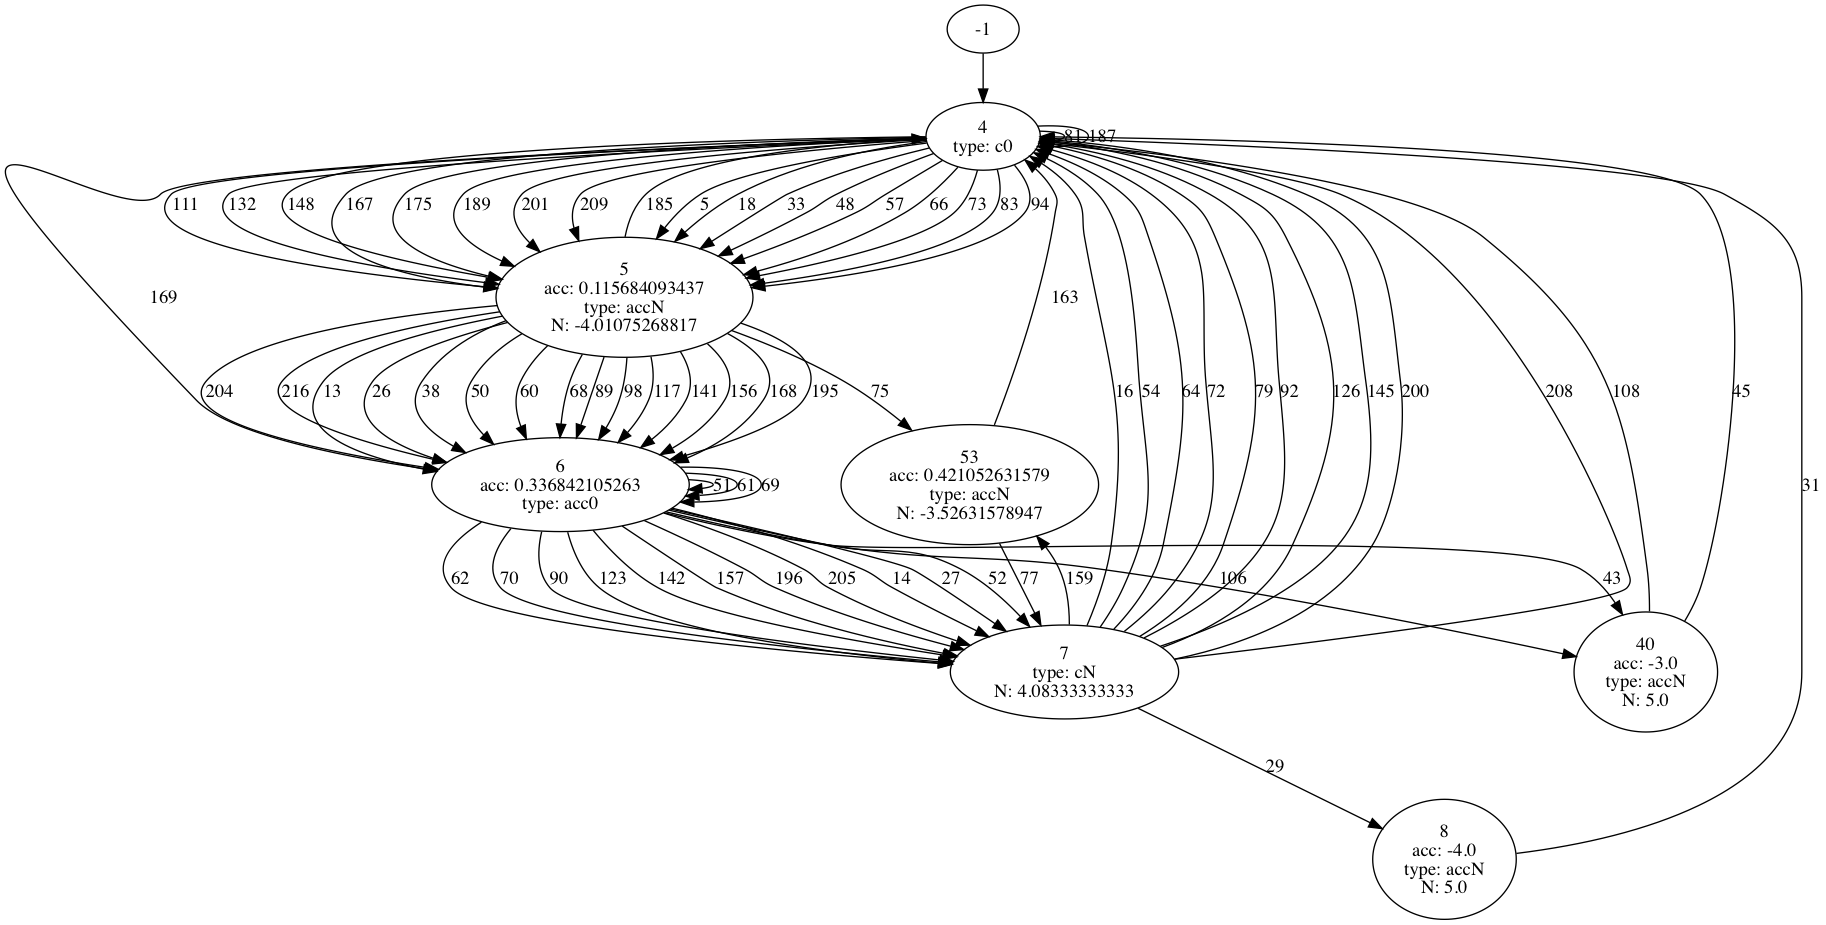

In [5]:
G = nx.MultiDiGraph()
for tgt,srcs in entries_from.items():
    G.add_node(tgt,label=str(tgt))
    # Let's learn about tgt
    mtype = path[tgt][1][2][0]
    mparams = path[tgt][1][2][1].params
    params = {"type": mtype}
    if mtype == 'c0':
        pass
    elif mtype == 'cP':
        pass
    elif mtype == 'cN':
        params["N"] = mparams[1]
    elif mtype == 'acc0':
        params["acc"] = mparams[1]
    elif mtype == 'accP':
        params["acc"] = mparams[1]
    elif mtype == 'accN':
        params["N"] = mparams[1]
        params["acc"] = mparams[2]
    for k,v in params.items():
        G.node[tgt]["label"] = (G.node[tgt]["label"] + "\n" + "{}: {}".format(k,v))
    print tgt,params
    for src,times in srcs.items():
        for t in times:
            G.add_edge(src,tgt,label=t)

G.add_node(-1)
G.add_edge(-1, unions[0])

m2i = {m:i for i,m in enumerate(merged)}
plt.plot(velocities)
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
for u in sorted(unions):
    t0 = all_times[path[u][1][0]]
    t1 = all_times[path[u][1][1]]
    u_ = m2i[unions[u]]
    plt.plot([t0,t1],[unions[u]+10,unions[u]+10])#,colors[u])
        
plt.xlim((50,100))
plt.show()


nxpd.draw(G, show='ipynb')

In [6]:

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        b_ = int(b)
        buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if b_ & (1 << (7-ii)):
                buttons.append(c)
        l_ = int(last_mask)
        last_buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if l_ & (1 << (7-ii)):
                last_buttons.append(c)
        mask_times[t] = (tuple(last_buttons),tuple(buttons))
        last_mask = b
    
    return mask_times

button_change_times = button_changes(inputVec)
for t in sorted(button_change_times):
    print t, button_change_times[t]

0 ((), ())
1 ((), ())
2 ((), ())
3 ((), ())
4 ((), ())
5 ((), ())
6 ((), ())
7 ((), ())
8 ((), ())
9 ((), ())
10 ((), ())
11 ((), ())
12 ((), ())
13 ((), ())
14 ((), ())
15 ((), ())
16 ((), ())
17 ((), ())
18 ((), ())
19 ((), ())
20 ((), ())
21 ((), ())
22 ((), ())
23 ((), ())
24 ((), ())
25 ((), ())
26 ((), ())
27 ((), ())
28 ((), ())
29 ((), ())
30 ((), ())
31 ((), ())
32 ((), ())
33 ((), ())
34 ((), ())
35 ((), ())
36 ((), ())
37 ((), ())
38 ((), ())
39 ((), ())
40 ((), ())
41 ((), ())
42 ((), ())
43 ((), ())
44 ((), ())
45 ((), ())
46 ((), ())
47 ((), ())
48 ((), ())
49 ((), ())
50 ((), ())
51 ((), ())
52 ((), ())
53 ((), ())
54 ((), ())
55 ((), ())
56 ((), ())
57 ((), ())
58 ((), ())
59 ((), ())
60 ((), ())
61 ((), ())
62 ((), ())
63 ((), ())
64 ((), ())
65 ((), ())
66 ((), ())
67 ((), ())
68 ((), ())
69 ((), ())
70 ((), ())
71 ((), ())
72 ((), ())
73 ((), ())
74 ((), ())
75 ((), ())
76 ((), ())
77 ((), ())
78 ((), ())
79 ((), ())
80 ((), ())
81 ((), ())
82 ((), ())
83 ((), ())
84

In [7]:
def sign(num):
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

def button_diff(btnsA, btnsB):
    return set(btnsA) - set(btnsB)

def button_intersect(btnsA, btnsB):
    return set(btnsA) & set(btnsB)

def button_union(btnsA, btnsB):
    return set(btnsA) | set(btnsB)

def button_preds(button_pairs_by_time):
    here_i = set()
    for bp,off in button_pairs_by_time:
        released_i = button_diff(bp[0], bp[1])
        pressed_i = button_diff(bp[1], bp[0])    
        held_i = bp[1]
        for ri in released_i:
            here_i.add(("release",ri,off))
        for ri in pressed_i:
            here_i.add(("press",ri,off))
        for ri in held_i:
            here_i.add(("hold",ri,off))
    return list(here_i)

In [8]:
preds = [set()]*len(velocities)
for t in range(0,len(velocities)):
    psi = ([(button_change_times[start_time+t+i],i)
            for i in range(-2, 1)],
            #  TODO: stopped colliding/started colliding?  That would mean
           #   I could say "started colliding with X on bottom and also zin,-1"
           #   to help find solid things.
           #     ... no... acc,0 should be enough (walking right across solid tiles)
           #     but I should also consider 
           #     a more sophisticated notion of collision.
           #      e.g. "bottom" is good but it should be the lowest bottom tile.
           #      how can I get that?  can I get that?
           #      (OTOH, maybe this isn't even necessary if e.g. "touching my feet against sky"
          #        doesn't cause vy=0 as often as "touching my feet against ground" does. so let's be
          #         sure that's surfaced!)
           # TODO: collisions of previous time and previous previous time also
            collisions.get(start_time+t+(0),set()),
            (velocities[t-1],velocities[t-0])
          )
    buttons_i = psi[0]
    here_i = button_preds(buttons_i)
    for coli in psi[1]:
        here_i.append(("col",coli))
    vel0,vel1 = psi[2]
    if vel0 < vel1:
        here_i.append(("acc",1))
    if vel0 > vel1:
        here_i.append(("acc",-1))
    if vel0 == vel1:
        here_i.append(("acc",0))
    if vel1 < 0:
        here_i.append(("vel",-1))
    if vel1 > 0:
        here_i.append(("vel",1))
    if vel1 == 0:
        here_i.append(("vel",0))
    if vel0 < 0 and vel1 > 0:
        here_i.append(("zc",1))
    if vel0 > 0 and vel1 < 0:
        here_i.append(("zc",-1))
    if vel0 < 0 and vel1 == 0:
        here_i.append(("zin",1))
    if vel0 > 0 and vel1 == 0:
        here_i.append(("zin",-1))
    if vel0 == 0 and vel1 < 0:
        here_i.append(("zout",-1))
    if vel0 == 0 and vel1 > 0:
        here_i.append(("zout",1))
    #cur_mode = X
    # TODO in_mode X predicate
    # TODO: touched global min/max of velocity for current mode
    #mode_max = max(velocities_in_cur_mode)
    #mode_min = min(velocities_in_cur_mode)
    #if vel1 == mode_max and vel0 != mode_max:
    #  touched max
    #if vel1 == mode_min and vel0 != mode_min:
    #  touched min
    #if vel1 == mode_max:
    #  in min
    #if vel1 == mode_min:
    #  in max
    preds[t] = set(here_i)

preds[270+59]

{('acc', 0),
 ('col', ((36, 0, 'tile'), 'bottom')),
 ('col', ((36, 0, 'tile'), 'internal')),
 ('col', ((36, 0, 'tile'), 'right')),
 ('col', ((38, 0, 'tile'), 'internal')),
 ('col', ((38, 0, 'tile'), 'left')),
 ('col', ((38, 0, 'tile'), 'right')),
 ('col', ((38, 0, 'tile'), 'top')),
 ('col', ((51, 0, 'tile'), 'bottom')),
 ('col', ((51, 0, 'tile'), 'internal')),
 ('col', ((51, 0, 'tile'), 'left')),
 ('col', ((51, 0, 'tile'), 'right')),
 ('col', ((52, 0, 'tile'), 'left')),
 ('hold', 'A', -1),
 ('hold', 'A', 0),
 ('press', 'A', -1),
 ('vel', -1)}

In [9]:

# TODO: change to include a "while_in_mode" argument
def count_cooccurrences(pred_sets,ignored):
    ocs = {}
    coocs = {}
    nice_pred_sets = []
    for pi in range(0, len(pred_sets)):
        here_i = pred_sets[pi]
        here_i = list(set(here_i) - ignored)
        for pred in here_i:
            ocs[pred] = ocs.get(pred,0)+1
        for predii in range(0,len(here_i)):
            if here_i[predii] not in coocs:
                coocs[here_i[predii]] = {}
            for predij in range(0,len(here_i)):
                coocs[here_i[predii]][here_i[predij]] = coocs[here_i[predii]].get(here_i[predij],0)+1
        nice_pred_sets.append(here_i)
    return nice_pred_sets,ocs,coocs


def calc_npmi(pred_sets, ocs, coocs):
    maximum = float(len(pred_sets))
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in ocs.items():
        px = countx / maximum
        probs[predx] = px
        for predy,countxy in coocs[predx].items():
            py = ocs[predy] / maximum
            pxy = countxy / maximum
            d = (math.log(px*py)/math.log(pxy) - 1) if pxy != 1 else 1
            npmis[(predx,predy)] = d
    return probs,npmis

def calc_npmi_pred_edge(all_ocs, all_edge_ocs, edge_count, all_edge_count):
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in all_ocs.items():
        px = countx / float(all_edge_count)
        py = edge_count / float(all_edge_count)
        pxy = all_edge_ocs.get(predx,0) / float(all_edge_count)
        probs[predx] = all_edge_ocs.get(predx,0) / float(edge_count)
        assert px <= 1, (px,countx,all_edge_count)
        assert py <= 1, (py,edge_count,all_edge_count)
        assert pxy <= 1, (pxy,all_edge_ocs.get(predx,0),float(edge_count))
        if pxy == 0:
            d = -1
        elif pxy == 1:
            d = 1
        else:
            d = (math.log(px*py)/math.log(pxy) - 1)
        npmis[predx] = d
    return probs,npmis

def calc_npmi(pred1, pred2, all_counts, counts_by_time):
    norm = float(len(counts_by_time)+1)
    count1 = all_counts[pred1]
    count2 = all_counts[pred2]
    count12 = 0
    for t,cs in counts_by_time.items():
        count12 += cs.get(pred1,0) * cs.get(pred2,0)
    p1 = count1 / norm
    p2 = count2 / norm
    p12 = count12 / norm
    if p12 == 0:
        d = -1
    elif p12 == 1:
        d = 1
    else:
        d = math.log(p1*p2)/math.log(p12) - 1
    return d

def weight_npmi(npmi, things):
    net_weight = 0
    WEIGHT_HIGH = 1.00
    WEIGHT_MID = 0.75
    WEIGHT_NORMAL = 0.50
    for t in things:
        weight = WEIGHT_NORMAL
        type = t[0]
        if type == "tr" or type == "press" or type == "release":
            weight = WEIGHT_HIGH
        elif type == "hold" or type == "col":
            weight = WEIGHT_MID
        else:
            weight = WEIGHT_NORMAL
        net_weight += weight
    weight = net_weight / float(len(things))
    return (npmi * weight)


In [10]:
def count_events(preds):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        counts_by_time[t] = {}
        for p in ps:
            all_counts[p] = all_counts.get(p,0)+1
            counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
        if t in transitions:
            tr = transitions[t]
            key = ("tr",tr)
            all_counts[key] = all_counts.get(key,0)+1
            counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
            (_,dest) = tr
            keystar = ("tr",("*",dest))
            all_counts[keystar] = all_counts.get(keystar,0)+1
            counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts, counts_by_time

all_counts,counts_by_time = count_events(preds)
all_counts,counts_by_time

({('acc', -1): 117,
  ('acc', 0): 673,
  ('acc', 1): 209,
  ('col', ((5, 6), 'bottom')): 10,
  ('col', ((8, 5, 6, 7), 'right')): 2,
  ('col', ((8, 9, 10, 7), 'bottom')): 1,
  ('col', ((8, 9, 10, 7), 'top')): 1,
  ('col', ((36, 0, 'tile'), 'bottom')): 876,
  ('col', ((36, 0, 'tile'), 'internal')): 875,
  ('col', ((36, 0, 'tile'), 'left')): 828,
  ('col', ((36, 0, 'tile'), 'right')): 844,
  ('col', ((36, 0, 'tile'), 'top')): 593,
  ('col', ((36, 3, 'tile'), 'bottom')): 4,
  ('col', ((36, 3, 'tile'), 'internal')): 2,
  ('col', ((36, 3, 'tile'), 'right')): 2,
  ('col', ((37, 0, 'tile'), 'internal')): 20,
  ('col', ((37, 0, 'tile'), 'left')): 20,
  ('col', ((37, 0, 'tile'), 'right')): 19,
  ('col', ((37, 0, 'tile'), 'top')): 7,
  ('col', ((38, 0, 'tile'), 'bottom')): 111,
  ('col', ((38, 0, 'tile'), 'internal')): 197,
  ('col', ((38, 0, 'tile'), 'left')): 158,
  ('col', ((38, 0, 'tile'), 'right')): 158,
  ('col', ((38, 0, 'tile'), 'top')): 81,
  ('col', ((48, 0, 'tile'), 'bottom')): 41,
  (

In [11]:
# Let's figure out which tiles block movement on which sides!
# co-occurrence of (col, BLAH) and acc0 for each BLAH.
# cluster together tiles which block on a given side (for now, all those with co-occurrence over threshold)
# then add new preds!

def cond_prob(e1s, e2, all_counts, counts_by_time):
    p2 = all_counts[e2]/float(len(counts_by_time))
    count12 = 0
    for t,cs in counts_by_time.items():
        any_e1_present = False
        for e1 in e1s:
            if e1 in cs:
                any_e1_present = True
                break
        if any_e1_present and (e2 in cs):
            count12 += 1
    p12 = count12 / float(len(counts_by_time))
    return p12 / p2

block_chance = {}
for thing,count in all_counts.items():
    # TODO: generalize back to all sides, but note "colliding on right with something" -> "vely=0" is not that sensible.
    #  need a notion of acc,vel,zin,zout and _other axis_ acc,vel,zin,zout.
    if thing[0] != "col": 
        continue
    block_chance[thing] = cond_prob([("vel",0),("acc",0)], 
                                    thing,
                                    all_counts,
                                    counts_by_time)

merged_by_side = {}
# TODO: generalize back to all sides
for side in ["bottom","right","left","top"]:
    # Let's pretend colliding with sprites is the same as colliding with tiles?  Maybe needed for moving platforms?
    blockings = filter(lambda (col,prob):(col[1][0][0] != "solid" and 
                                          col[1][1] == side and 
                                          prob > 0.8),
                       block_chance.items())
    merged_by_side[side] = set()
    for bcol,bprob in blockings:
        merged_by_side[side].add(bcol)
    merged_by_side[side] = sets.ImmutableSet(merged_by_side[side])
        
    
#color_tiles = pickle.load(open('tile2colorized.pkl'))
for side,bcols in merged_by_side.items():
    print "----\n{}\n----".format(side)
    for bc in bcols:
        print block_chance[bc],bc[1][0]        

----
top
----
1.0 (53, 0, 'tile')
0.828571428571 (87, 3, 'tile')
0.949367088608 (180, 1, 'tile')
0.949367088608 (181, 1, 'tile')
0.909090909091 (88, 3, 'tile')
----
right
----
0.840579710145 (51, 0, 'tile')
1.0 (49, 0, 'tile')
0.854430379747 (38, 0, 'tile')
0.894736842105 (37, 0, 'tile')
0.925619834711 (48, 0, 'tile')
0.833333333333 (52, 0, 'tile')
0.913043478261 (54, 0, 'tile')
----
left
----
0.913043478261 (54, 0, 'tile')
0.913043478261 (52, 0, 'tile')
0.804347826087 (48, 0, 'tile')
0.974683544304 (56, 0, 'tile')
0.835443037975 (38, 0, 'tile')
0.85 (37, 0, 'tile')
----
bottom
----
1.0 (8, 9, 10, 7)
0.877551020408 (51, 0, 'tile')
0.900900900901 (38, 0, 'tile')
0.926829268293 (48, 0, 'tile')
0.941176470588 (55, 0, 'tile')
0.941176470588 (54, 0, 'tile')
0.920634920635 (52, 0, 'tile')


In [12]:
# Let's add new preds now!
new_preds = [set() for i in range(0,len(preds))]
for t,pset in enumerate(preds):
    for side,equiv in merged_by_side.items():
        found = False
        for pred in pset:
            new_preds[t].add(pred)
            if not found and pred[0] == "col" and pred in equiv:
                new_preds[t].add(("col", (("solid", equiv), side)))
                found = True
all_counts,counts_by_time = count_events(new_preds)


all_counts,counts_by_time

({('acc', -1): 117,
  ('acc', 0): 673,
  ('acc', 1): 209,
  ('col', ((5, 6), 'bottom')): 10,
  ('col', ((8, 5, 6, 7), 'right')): 2,
  ('col', ((8, 9, 10, 7), 'bottom')): 1,
  ('col', ((8, 9, 10, 7), 'top')): 1,
  ('col', ((36, 0, 'tile'), 'bottom')): 876,
  ('col', ((36, 0, 'tile'), 'internal')): 875,
  ('col', ((36, 0, 'tile'), 'left')): 828,
  ('col', ((36, 0, 'tile'), 'right')): 844,
  ('col', ((36, 0, 'tile'), 'top')): 593,
  ('col', ((36, 3, 'tile'), 'bottom')): 4,
  ('col', ((36, 3, 'tile'), 'internal')): 2,
  ('col', ((36, 3, 'tile'), 'right')): 2,
  ('col', ((37, 0, 'tile'), 'internal')): 20,
  ('col', ((37, 0, 'tile'), 'left')): 20,
  ('col', ((37, 0, 'tile'), 'right')): 19,
  ('col', ((37, 0, 'tile'), 'top')): 7,
  ('col', ((38, 0, 'tile'), 'bottom')): 111,
  ('col', ((38, 0, 'tile'), 'internal')): 197,
  ('col', ((38, 0, 'tile'), 'left')): 158,
  ('col', ((38, 0, 'tile'), 'right')): 158,
  ('col', ((38, 0, 'tile'), 'top')): 81,
  ('col', ((48, 0, 'tile'), 'bottom')): 41,
  (

In [13]:
# Let's calculate NPMI between predicates and transitions!
npmis = {}    
for thing,count in all_counts.items():
    if thing[0] == "tr":
        print "tr:",thing,count
        tr = thing[1]
        # Find NPMI with every predicate
        for thing2,count in all_counts.items():
            if thing2[0] == "tr":
                continue
            if tr not in npmis:
                npmis[tr] = {}
            npmis[tr][(thing2,)] = weight_npmi(
                calc_npmi(thing, 
                          thing2, 
                          all_counts,
                          counts_by_time),
                [thing2]
            )
    else:
        pass

for tr,prednpmis in npmis.items():
    if tr[1] != 5: continue
    print "----"
    print tr
    print "----"
    for pred,pmi in sorted(prednpmis.items(),
                           lambda a,b:sign(b[1]-a[1])):
        if pmi > 0:
            print pred,pmi

tr: ('tr', (5, 4)) 1
tr: ('tr', (4, 4)) 2
tr: ('tr', (5, 6)) 15
tr: ('tr', ('*', 53)) 2
tr: ('tr', (4, 5)) 17
tr: ('tr', (6, 6)) 3
tr: ('tr', (5, 53)) 1
tr: ('tr', ('*', 6)) 18
tr: ('tr', ('*', 5)) 17
tr: ('tr', (40, 4)) 2
tr: ('tr', ('*', 4)) 18
tr: ('tr', ('*', 8)) 1
tr: ('tr', (6, 7)) 11
tr: ('tr', (53, 7)) 1
tr: ('tr', (7, 53)) 1
tr: ('tr', (53, 4)) 1
tr: ('tr', ('*', 40)) 2
tr: ('tr', (8, 4)) 1
tr: ('tr', (7, 4)) 10
tr: ('tr', (6, 4)) 1
tr: ('tr', (7, 8)) 1
tr: ('tr', ('*', 7)) 12
tr: ('tr', (6, 40)) 2
----
('*', 5)
----
(('press', 'A', 0),) 0.925812305604
(('release', 'L', -1),) 0.478860388158
(('zout', -1),) 0.457683527155
(('release', 'B', -1),) 0.430809941301
(('release', 'L', -2),) 0.330466609413
(('press', 'L', 0),) 0.330466609413
(('col', ((53, 0, 'tile'), 'internal')),) 0.323107455976
(('col', ((53, 0, 'tile'), 'right')),) 0.267645268571
(('acc', -1),) 0.263291110811
(('col', ((87, 3, 'tile'), 'top')),) 0.20886981498
(('col', ((88, 3, 'tile'), 'top')),) 0.202343410346
(('c

In [14]:
# # TODO: this gives different results if e2, e3 in different 
# #  orders.  Seems wrong!
# def calc_npmi_chained(e1,e2,e3,all_counts,counts_by_time):
#     p1 = all_counts[e1] / float(len(counts_by_time)+1)
#     p2 = all_counts[e2] / float(len(counts_by_time)+1)
#     if p1 == 0:
#         assert(False)
#         print "p1=0"
#         return -1
#     if p2 == 0:
#         assert(False)
#         print "p2=0"
#         return -1
#     count12 = 0
#     for t,cs in counts_by_time.items():
#         if (e1 in cs) and (e2 in cs):
#             count12 += 1
#     p12 = count12 / float(len(counts_by_time)+1)
#     if p12 == 0:
#         # Never co-occur, avoid log(0)
#         return -1
#     pmi12 = math.log(p12 / (p1 * p2))
#     #p(event ,  causeB| causeA)/ (p(event | causeA) * p(causeB | causeA))
#     times_1_and_3_and_2_happen = 0
#     times_3_and_2_happen = 0
#     times_any_happen = 0
#     for t,cs in counts_by_time.items():
#         if (e1 in cs) and (e3 in cs) and (e2 in cs):
#             times_1_and_3_and_2_happen += 1
#         if (e3 in cs) and (e2 in cs):
#             times_3_and_2_happen += 1
#         if (e1 in cs) or (e2 in cs) or (e3 in cs):
#             times_any_happen += 1
#     p132 = times_1_and_3_and_2_happen/float(len(counts_by_time)+1)
#     if p132 == 0:
#         # Never co-occur, avoid log(0)
#         return -1
#     # TODO: P(x,(z|y)) or P((x,z)|y)?  this looks like the latter.  Because the former makes no sense?
#     p13_2 = (p132/p2)
#     p32 = times_3_and_2_happen / float(len(counts_by_time)+1)
#     p3_2 = p32/p2
#     if p13_2 == 0:
#         # Never co-occur, avoid log(0)
#         return -1
#     elif p3_2 == 0:
#         # Never co-occur, avoid log(0)
#         return -1
#     pmi1_23 = math.log(p13_2/(p1 * p3_2))
#     # normalize by log(p(event;causeA;causeB))??? no...
#     # Normalize by self-information!
#     return (pmi12 + pmi1_23)/(2*(-math.log(p132)))

# # Let's calculate the NPMI of causal pairs with each transition!
# paired_npmis = {}
# for thing,count in all_counts.items():
#     if thing[0] == "tr":
#         print "tr:",thing,count
#         tr = thing[1]
#         if tr not in paired_npmis:
#             paired_npmis[tr] = {}
#         # Find NPMI with every predicate
#         for thing2,count2 in all_counts.items():
#             if thing2[0] == "tr":
#                 continue
#             for thing3,count3 in all_counts.items():
#                 if thing3[0] == "tr" or thing3 == thing2:
#                     continue
#                 key = (thing2,thing3)
#                 paired_npmis[tr][key] = weight_npmi(
#                     calc_npmi_chained(thing,
#                                       thing2,
#                                       thing3,
#                                       all_counts,
#                                       counts_by_time),
#                     [thing2,thing3]
#                 )
#         print "\n".join(
#             map(str,
#                 sorted(filter(
#                         lambda (k,v): v > 0,
#                         paired_npmis[tr].items()),
#                        lambda a,b:sign(b[1]-a[1]))))
        
#     else:
#         pass

In [18]:
relevance_threshold = 0.1
universality_threshold = 0.8
negation_threshold = -1.0

for tr,pred_npmis in npmis.items():# + paired_npmis.items():
    if tr[1] != 5: continue

    cond_probs = {k: cond_prob(list(k), ("tr",tr), all_counts, counts_by_time) for k in pred_npmis.keys()}
    relevants = {k: npmi for (k,npmi) in pred_npmis.items() if npmi >= relevance_threshold}
    negations = {k: npmi for (k,npmi) in pred_npmis.items() if npmi <= negation_threshold}
    conjuncts = set(filter(lambda k:cond_probs[k] >= universality_threshold, relevants.keys()))
    disjuncts = set(filter(lambda k:cond_probs[k] < universality_threshold, relevants.keys()))
    print "-------\nTransition:",tr
    print "\n".join(map(str,cond_probs.items()))
    print "-----\nRelevant:\n","\n".join(map(str,relevants.items()))
    print "-----\nConjuncts:\n"," & ".join(map(str,conjuncts))
    print "-----\nDisjuncts:\n"," | ".join(map(str,disjuncts))
    print "-----\nNegations:\n"," & ".join(map(lambda k:"~" + str(k),negations))
    
    


-------
Transition: ('*', 5)
((('hold', 'A', 0),), 1.0)
((('release', 'R', 0),), 0.0)
((('col', ((52, 0, 'tile'), 'bottom')),), 0.1176470588235294)
((('press', 'A', -1),), 0.0)
((('hold', 'L', -2),), 0.1176470588235294)
((('col', ((48, 0, 'tile'), 'top')),), 0.0)
((('col', ((38, 0, 'tile'), 'right')),), 0.4117647058823529)
((('press', 'A', 0),), 1.0)
((('col', ((56, 0, 'tile'), 'internal')),), 0.0588235294117647)
((('col', ((52, 0, 'tile'), 'top')),), 0.0)
((('col', ((48, 0, 'tile'), 'bottom')),), 0.1176470588235294)
((('col', ((49, 0, 'tile'), 'right')),), 0.0)
((('col', ((55, 0, 'tile'), 'internal')),), 0.0588235294117647)
((('col', ((180, 1, 'tile'), 'top')),), 0.8235294117647058)
((('col', ((36, 3, 'tile'), 'internal')),), 0.0)
((('col', ((87, 3, 'tile'), 'right')),), 0.0)
((('col', ((49, 0, 'tile'), 'internal')),), 0.0)
((('col', ((49, 0, 'tile'), 'bottom')),), 0.0)
((('acc', 0),), 0.0)
((('release', 'B', 0),), 0.0)
((('col', ((89, 3, 'tile'), 'right')),), 0.0)
((('acc', -1),), 1.

In [17]:
pickle.dump((npmis, entries, entries_from, new_preds, modes, merged, unions, track, inputVec, all_times), 
            open("edges.pkl",'wb'))